<center> <h1> Lab 8: Vector Quantization and Its Applications: Evaluating Generative Models, Nearest Neighbor Search  </h1> </center>
<center> Krishna Pillutla (Guest Lecturer), Jillian Fisher, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2023), University of Washington </center>


Some of the material below on generative models was developed together with [Lang Liu](https://langliu95.github.io/).


The outline of this lab is as follows: 

**Part 1**: Evaluating Generative Models

**Part 2**: Near Neighbor Search Using Vector Quantization

**Part 3**: Learning Features for Lattice Quantization

### Packages
We will need some additional packages for this lab. Run:
```
pip install plotly datasets tqdm faiss-cpu
```

In [1]:
import torch
import torchvision
import numpy as np

import time

import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Evaluating Generative Models

## Real-world Generative Models

We will experiment with recent generative models for text.

We will use an autoregressive transformer language model called GPT-2, a precursor to ChatGPT. While it is not as good as the recent models, GPT-2 is small enough to use on our laptops. 

**Trigger Warning**: The model could generate offensive text. Use at your own risk. 

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Download the pre-trained model + tokenizer 
model_name = 'gpt2'   # ~500 MB in size
# model_name = "gpt2-large"  # For better results, ~2 GB in size

tokenizer = GPT2Tokenizer.from_pretrained(model_name) # to tokenize the text
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id)  # PyTorch module


In [9]:
prompt = "Adele’s third album, 25, sold 5m copies in the US after it went on sale in November."

encoded_input = tokenizer.encode(prompt, return_tensors='pt')

generated_tokens = model.generate(encoded_input, do_sample=True, max_length=200, top_k=5)

generated_text = tokenizer.decode(generated_tokens[0])

print(generated_text)

Adele’s third album, 25, sold 5m copies in the US after it went on sale in November. The band also released two new albums, 'The Last Word' (2012) and 'I Don't Want To Know (2012), in 2013.

The band released their fifth album, 'I Don't Want To Know', in November, and it was their first full album since 'We Don't Want To Be Lonely' in 2012.

In the past, they've released three albums in the UK and two in the US.

They released a second album, 'I Want to Know', in November, and it was their first full album since 'I Don't Want To Know' in 2012.

In 2013 they announced a new album, 'I Want to Know', which was released in the UK and the US on the same day.

'I Want to Know' will be available for pre-order on the band's


The `top_k` argument determines how many candidate next tokens to sample from. 

### Exercise
Vary the `top_k` argument from 1 (choose the single most likely next token) 
to 5 to 50 to 500 and then 50000 (use all available tokens, you can also pass `top_k=0` for this). 

What do you observe in the quality of the generated text? 
- Under what settings does the model generate highly repetitive text? 
- When does the model produce text that is not meaningless? 
- When is the text reasonable?

## Evaluating Generative Models

A simply way to evaluate generative models is to look at each of the generated samples and quantify its quality.
However, this individual-level approach fails to quantify the diversity of the data.

A more realistic approach is to compare generative models with real data on a distribution level. To be more concrete, let $P$ be the real data distribution (e.g. text written by humans) and $Q$ be the distribution of some generative model (e.g. ChatGPT). The "closer" $Q$ is to $P$, the better the generative model is.


### The Quality-Variety Trade-off

When evaluating generative models, it is common to have two failure cases: (1) high quality but low variety; (2) low quality but high variety.

<div>
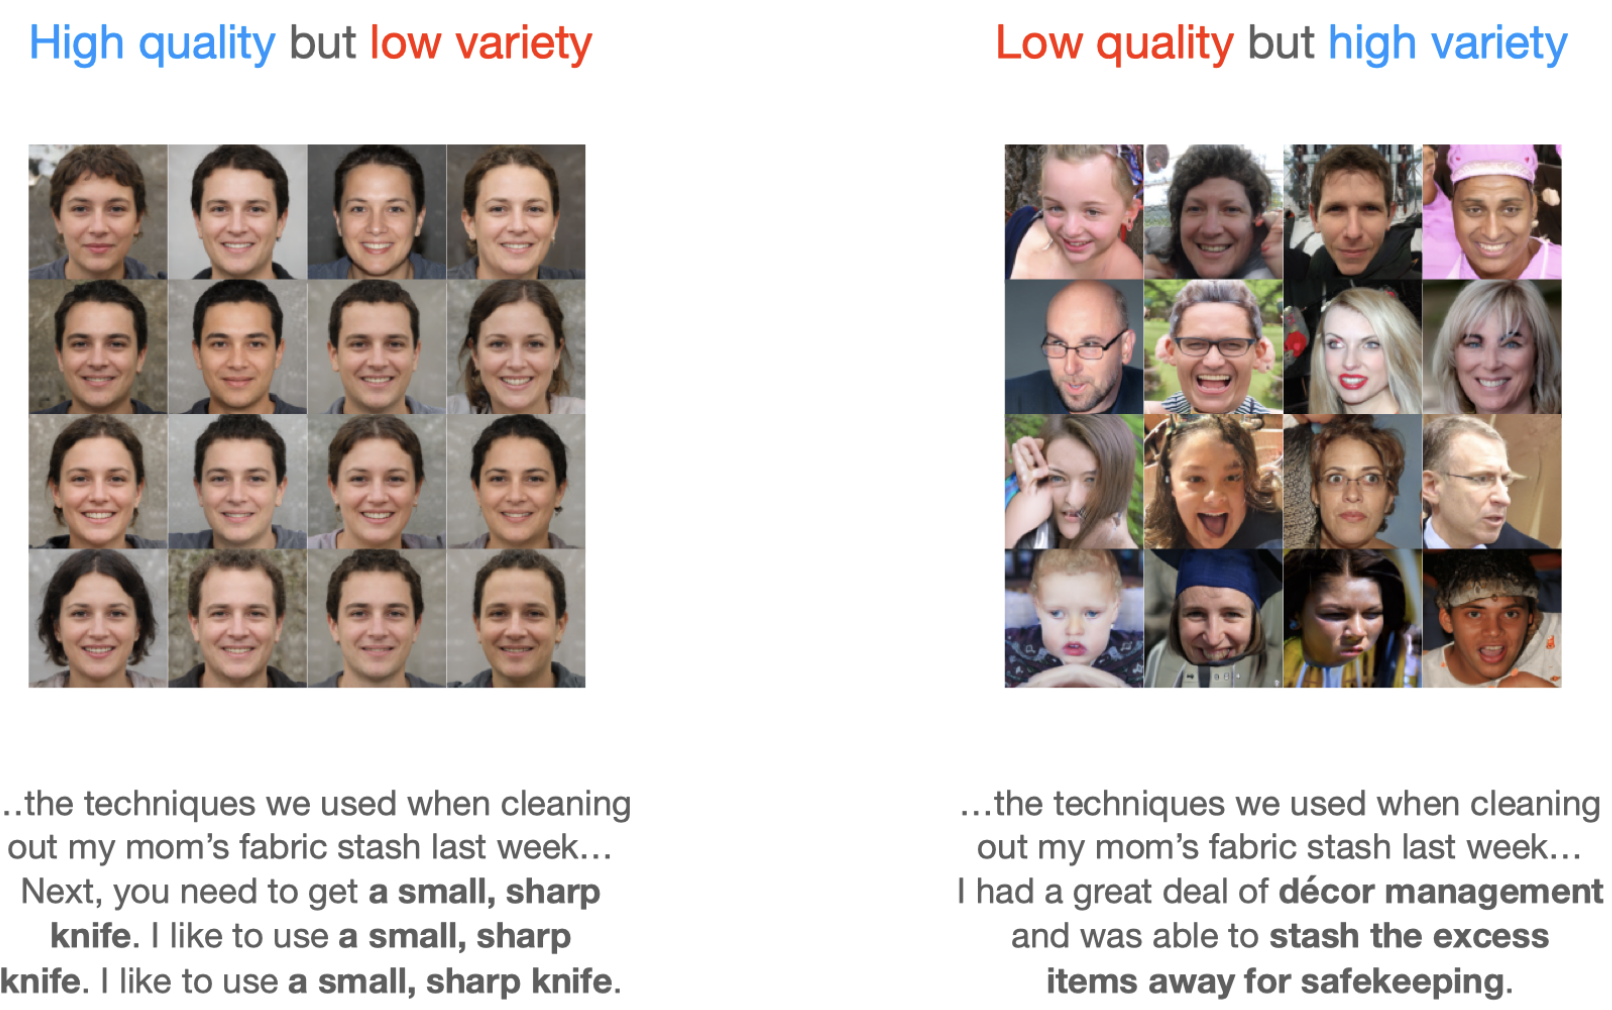
</div>


### Two Types of Errors

To describe the two failure cases, we introduce the notion of two types of errors -- (1) type I errors: samples that are highly likely to be generated by the model but less likely to exist in reality; (2) type II errors: samples that are highly likely to exist in reality but less likely to be generated by the model.
They can be quantified by the Kullback-Leibler (KL) divergences:
$$
\text{KL}(\color{red}{Q} \Vert \color{blue}{P}) := \int \log{\left( \frac{\color{red}{q(x)}}{\color{blue}{p(x)}} \right)} \color{red}{q(x)} dx \quad \text{and} \quad \text{KL}(\color{blue}{P} \Vert \color{red}{Q}) := \int \log{\left( \frac{\color{blue}{p(x)}}{\color{red}{q(x)}} \right)} \color{blue}{p(x)} dx
$$

<div>
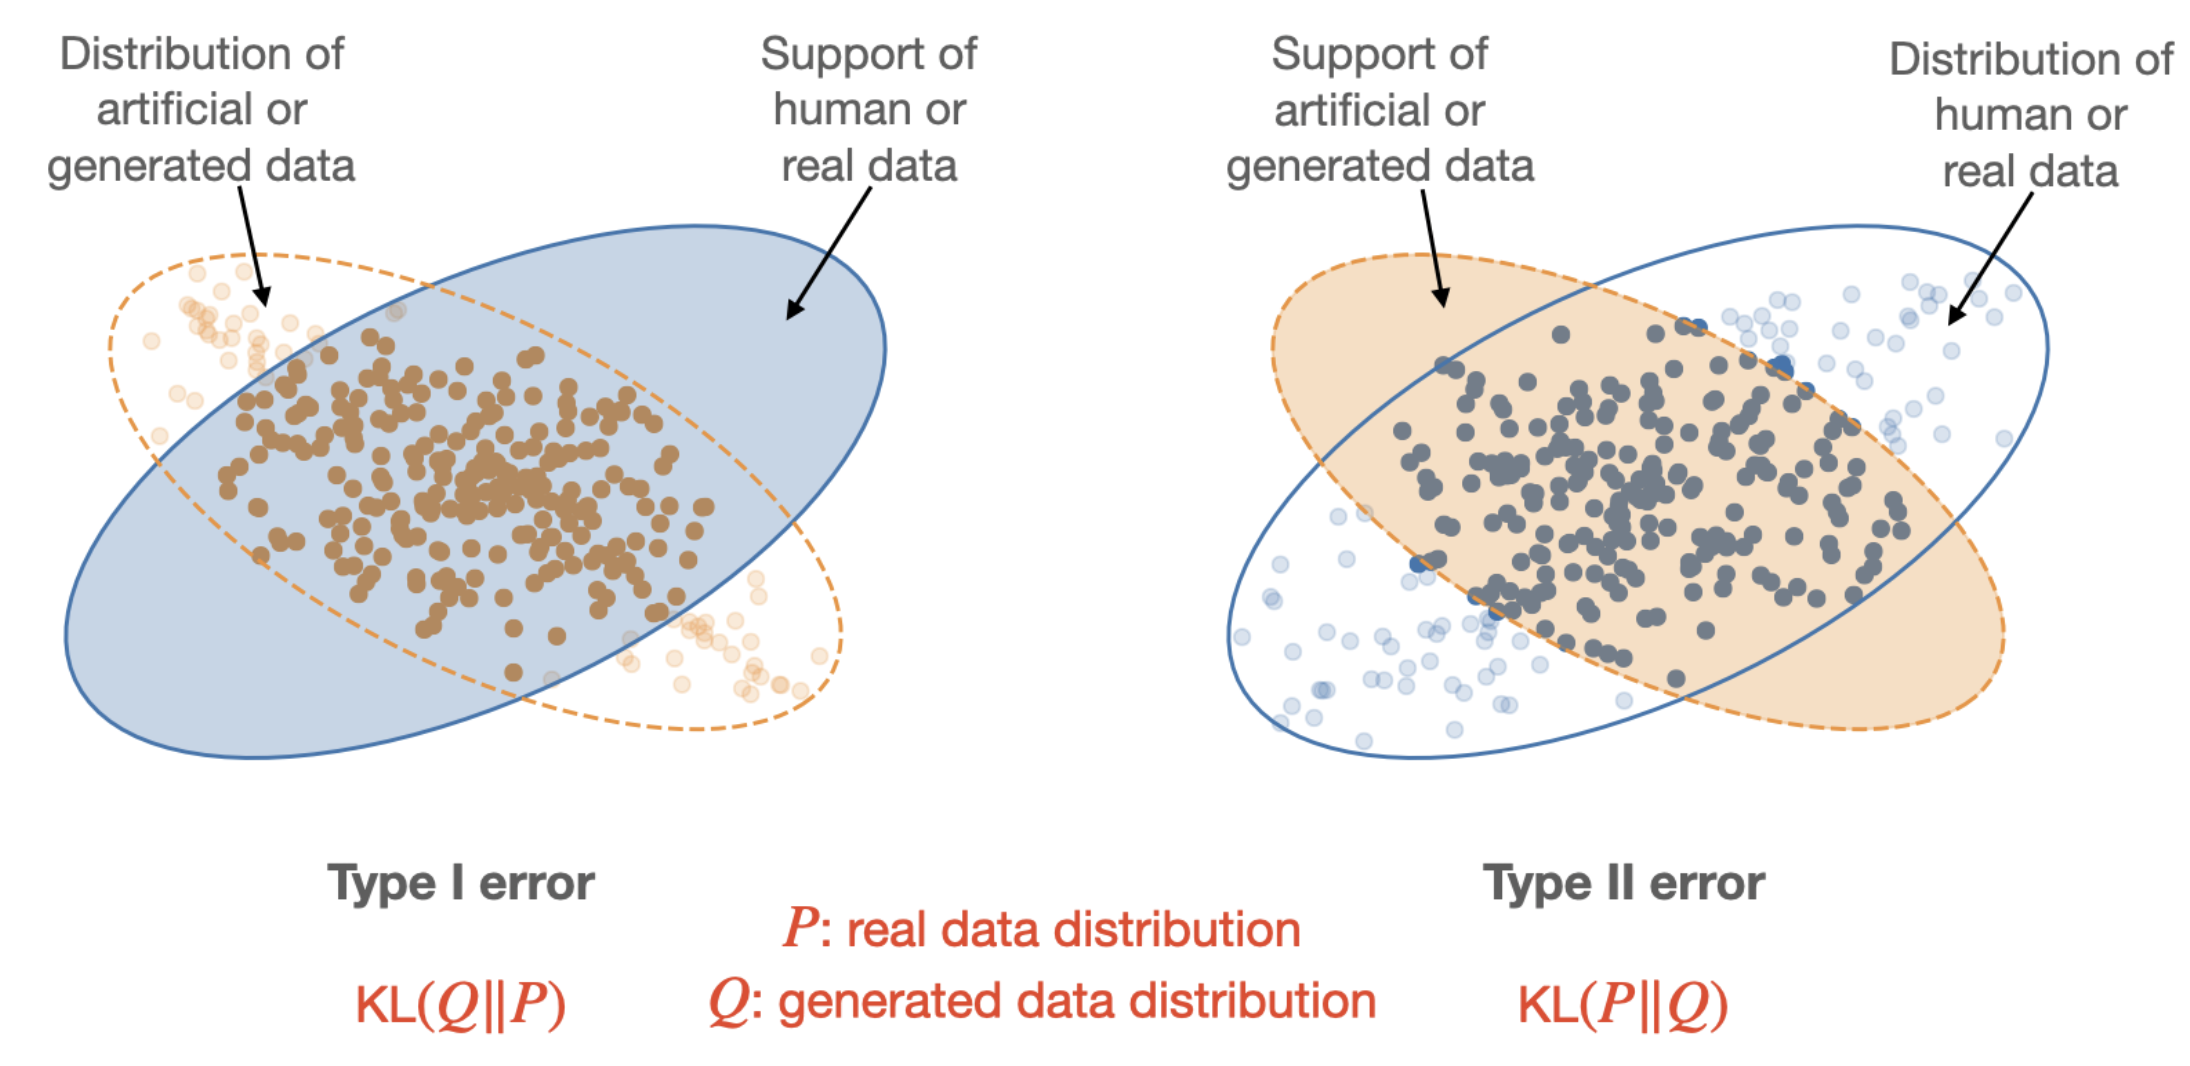
</div>


### Illustration of Two Types of Errors

Consider two distributions $P = 0.4 \mathcal{N}(-2.5, 1) + 0.6 \mathcal{N}(2.5, 1)$ and $Q = \mathcal{N}(\mu, 1.5)$.
Let us plot the two distributions and the two types of errors as we vary the mean $\mu$.

Please install the package `plotly` via `pip install plotly` before proceeding.

In [11]:
import numpy as np
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from scipy.stats import norm

In [12]:
# density of p
x = np.linspace(-10, 10, 200)
loc, scale = 2.5, 1.0
prob = 0.6
def pdensity(x):
    return (1 - prob)*norm.pdf(x, loc=-loc, scale=scale) + prob*norm.pdf(
    x, loc=loc, scale=scale)
px = pdensity(x)

# density of q
qscale = 2.0
def qdensity(x, qloc):
    return norm.pdf(x, loc=qloc, scale=qscale)

# samples of p and q
nsample = 500
def get_psample(nsample):
    latent = np.random.binomial(1, prob, size=nsample)
    psample = np.random.normal(-loc, scale, size=nsample)
    pos = latent == 1
    psample[pos] = np.random.normal(loc, scale, size=np.sum(pos))
    return psample

In [14]:
%matplotlib widget
# The line above is needed for jupyter lab users to
# see the interactive plot below.
# Jupyter lab users also need to install/update the package ipympl
# and restart jupyter lab.
# For details, see: https://stackoverflow.com/questions/50149562/jupyterlab-interactive-plot

# Create figure
fig = make_subplots(1, 2)

# Add traces of densities p(x) and q(x)
fig.add_trace(
    go.Scatter(x=x, y=px, name=r'$p(x)$', visible=True), row=1, col=1)  # p(x)
step_range = np.arange(-5, 5, 0.25)
num = len(step_range) + 1
for step in step_range:
    fig.add_trace(
        go.Scatter(
            visible=False,
            # line=dict(color="#00CED1", width=6),
            name=r'$q(x)$',
            x=x,
            y=norm.pdf(x, loc=step, scale=qscale)),
        row=1,
        col=1)

# Add traces of errors, i.e., KL(p||q) and KL(q||p).
for step in step_range:
    qsample = np.random.normal(step, qscale, size=nsample)
    type1 = np.mean(np.log(qdensity(qsample, step) / pdensity(qsample)))
    psample = get_psample(nsample)
    type2 = np.mean(np.log(pdensity(psample) / qdensity(psample, step)))
    fig.add_trace(
        go.Bar(
            visible=False,
            # line=dict(color="#00CED1", width=6),
            name='Errors',
            x=[r'$\text{KL}(q \Vert p)$', r'$\text{KL}(p \Vert q)$'],
            y=[type1, type2]),
        row=1,
        col=2)

# Make 8th trace visible
fig.data[8].visible = True
fig.data[num+8].visible = True

# Create and add slider
steps = []
for i in range(1, num):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to mean = " + str(np.round(step_range[i-1], 1))}],  # layout attribute
    )
    # Toggle visible trace
    step["args"][0]["visible"][0] = True
    step["args"][0]["visible"][i] = True
    step["args"][0]["visible"][num+i-1] = True
    steps.append(step)

sliders = [dict(
    active=8,
    currentvalue={"prefix": "Mean: "},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    yaxis2 = dict(range=[0, 5.5])
)

fig.show()

**Exercise**: 
Move the slider around and track the Type I and Type II errors. Is there any setting where there exists a trade-off between the two? 
That is, can you find a point where a reduction in the Type I error leads to an increase in the Type II error? 

Hint: vary the mean in the range 1.2 to 2.

## Generating some sample text distributions

We will generate text from three distributions: 
- loaded from a dataset (i.e., written by humans)
- generated by GPT-2
- Dummy Lipsum text

We will them measure the gap between these distributions.

In [16]:
def generate_text(prompt, i):
    # Prompt is a string
    if i is not None and (i+1) % 10 == 0:
        print(f'Generating {i+1}')
    # TODO: your code here
    # Generate text in continuation of the prompt:
    #   - Tokenize the prompt
    #   - Generate from the model
    #   - De-tokenize the generated text
    # See the code above for details
    # Use top_k=50 and max_length=50 in `model.generate`
    return generated_text

In [17]:
sample_size = 100  # the number of samples to create

In [18]:
# Run `pip install datasets` to download the HuggingFace datasets package
from datasets import load_dataset

# We download the Penn Tree Bank (PTB) data
ds = load_dataset('ptb_text_only')['validation']

# Load some sentences without the "<unk>" token
real_sentences = [ds[i]['sentence'] 
                  for i in range(500) 
                  if '<unk>' not in ds[i]['sentence']
                 ][:sample_size]

print('\n'.join(real_sentences[:3]))

Found cached dataset ptb_text_only (/Users/hridaybaghar/.cache/huggingface/datasets/ptb_text_only/penn_treebank/1.1.0/8d1b97746fb9765d140e569ec5ddd35e20af4d37761f5e1bf357ea0b081f2c1f)


  0%|          | 0/3 [00:00<?, ?it/s]

consumers may want to move their telephones a little closer to the tv set
and the new syndicated reality show hard copy records viewers ' opinions for possible airing on the next day 's show
we 've been spending a lot of time in los angeles talking to tv production people says mike parks president of call interactive which supplied technology for both abc sports and nbc 's consumer minutes


In [19]:
# Generate using GPT-2. This can take a few minutes.

# Use the first 5 words as a prompt
prompts = [' '.join(s.split()[:5]) for s in real_sentences]

gen_sentences = [generate_text(prompt, i) for i, prompt in enumerate(prompts)]
print('\n'.join(gen_sentences[:3]))

Generating 10
Generating 20
Generating 30
Generating 40
Generating 50
Generating 60
Generating 70
Generating 80
Generating 90
Generating 100
Adele’s third album, 25, sold 5m copies in the US after it went on sale in November. The band also released two new albums, 'The Last Word' (2012) and 'I Don't Want To Know (2012), in 2013.

The band released their fifth album, 'I Don't Want To Know', in November, and it was their first full album since 'We Don't Want To Be Lonely' in 2012.

In the past, they've released three albums in the UK and two in the US.

They released a second album, 'I Want to Know', in November, and it was their first full album since 'I Don't Want To Know' in 2012.

In 2013 they announced a new album, 'I Want to Know', which was released in the UK and the US on the same day.

'I Want to Know' will be available for pre-order on the band's
Adele’s third album, 25, sold 5m copies in the US after it went on sale in November. The band also released two new albums, 'The Last

In [20]:
# Run `pip install lorem` for dummy text generation

import lorem

lorem_sentences = [lorem.sentence() for _ in range(sample_size)]

print('\n'.join(lorem_sentences[:3]))

Porro eius aliquam magnam dolor adipisci sed.
Est tempora ipsum labore dolore.
Velit dolore sit adipisci ut quaerat porro magnam.


## Vector Quantization in the Evaluation of Generative Models

Text and images are complex objects. It is common to represent them with embeddings. 
However, since these embeddings are high dimensional, it is not easy to compute the KL divergences above directly.

One way to overcome this problem is using vector quantization via $k$-means. By grouping similar vectors together, we can compare the distributions over the resulting clusters.

### Featurizing Utility
We start with a utility function to obtain features of some text from GPT-2.

In [21]:
try:
    from tqdm.auto import tqdm
except ModuleNotFoundError:
    tqdm = lambda x: x  # No-op

# Code below is taken from https://github.com/krishnap25/mauve
@torch.no_grad()
def featurize_tokens_from_model(model, tokenized_texts, batch_size, name="", verbose=False):
    """Featurize tokenized texts using models, support batchify
    :param model: HF Transformers model
    :param batch_size: Batch size used during forward pass
    :param tokenized_texts: list of torch.LongTensor of shape (1, length)
    :param verbose: If True, print status and time
    :return:
    """
    device = next(model.parameters()).device
    t1 = time.time()
    feats, chunks, chunk_sent_lengths = [], [], []
    chunk_idx = 0

    while chunk_idx * batch_size < len(tokenized_texts):
        _chunk = [_t.view(-1) for _t in tokenized_texts[chunk_idx * batch_size: (chunk_idx + 1) * batch_size]]
        chunks.append(_chunk)
        chunk_sent_lengths.append([len(_c) for _c in _chunk])
        chunk_idx += 1

    for chunk, chunk_sent_length in tqdm(list(zip(chunks, chunk_sent_lengths)), desc=f"Featurizing {name}"):
        padded_chunk = torch.nn.utils.rnn.pad_sequence(chunk,
                                                       batch_first=True,
                                                       padding_value=0).to(device)
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [torch.ones(sent_length).long() for sent_length in chunk_sent_length],
            batch_first=True,
            padding_value=0).to(device)
        outs = model(input_ids=padded_chunk,
                     attention_mask=attention_mask,
                     past_key_values=None,
                     output_hidden_states=True,
                     return_dict=True)
        h = []
        for hidden_state, sent_length in zip(outs.hidden_states[-1], chunk_sent_length):
            h.append(hidden_state[sent_length - 1])
        h = torch.stack(h, dim=0)
        feats.append(h.cpu())
    t2 = time.time()
    if verbose:
        print(f'Featurize time: {round(t2-t1, 2)}')
    return torch.cat(feats)

### Tokenize and embed text samples

In [22]:
# Tokenize

gen_tokens = [tokenizer.encode(sentence, return_tensors='pt')
              for sentence in gen_sentences]
real_tokens = [tokenizer.encode(sentence, return_tensors='pt')
              for sentence in real_sentences]
lorem_tokens = [tokenizer.encode(sentence, return_tensors='pt')
                for sentence in lorem_sentences]

In [23]:
# Embed using the GPT2LMHeadModel we loaded earlier

batch_size = 5

gen_encodings = featurize_tokens_from_model(
    model, gen_tokens, batch_size, name="", verbose=False
)
real_encodings = featurize_tokens_from_model(
    model, real_tokens, batch_size, name="", verbose=False
)
lorem_encodings = featurize_tokens_from_model(
    model, lorem_tokens, batch_size, name="", verbose=False
)

print(gen_encodings.shape, real_encodings.shape, lorem_encodings.shape)

Featurizing :   0%|          | 0/20 [00:00<?, ?it/s]

Featurizing :   0%|          | 0/20 [00:00<?, ?it/s]

Featurizing :   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([100, 768]) torch.Size([100, 768]) torch.Size([100, 768])


### Vector Quantization of Text Embeddings
We are now ready to quantize the embeddings. We will use the package `faiss` to this end.

Once we cluster the embeddings, we will measure the total mass of each distribution per cluster:
$$
\hat P(i) = P\big( c(x) = i \big)
$$

In [28]:
import faiss

# Concatenate all the data
data = torch.cat([gen_encodings, real_encodings, lorem_encodings]).numpy()
print(data.shape)

# Cluster using k-means
num_clusters = 10
kmeans = faiss.Kmeans(data.shape[1], num_clusters,
                      niter=1000, verbose=True, nredo=1,
                      update_index=True, seed=1)
kmeans.train(data)  # Cluster

# Obtain the cluster labels
_, gen_labels = kmeans.index.search(gen_encodings, 1)  # Cluster the points
gen_labels = gen_labels.reshape(-1) # (sample_size,)
_, real_labels = kmeans.index.search(real_encodings, 1)  # Cluster the points
real_labels = real_labels.reshape(-1)# TODO
_, lorem_labels = kmeans.index.search(lorem_encodings, 1)  # Cluster the points
lorem_labels = lorem_labels.reshape(-1)# TODO


# Measure the mass per cluster
# Use the formula above
gen_histogram = gen_labels.sum() / gen_labels.shape[0]
...  # (num_clusters,)
real_histogram = ... # (num_clusters,)
lorem_histogram = ... # (num_clusters,)

print('gen_histogram:', gen_histogram)
print('real_histogram:', real_histogram)
print('lorem_histogram:', lorem_histogram)

(300, 768)
Clustering 300 points in 768D to 10 clusters, redo 1 times, 1000 iterations
  Preprocessing in 0.00 s


WARNING clustering 300 points to 10 centroids: please provide at least 390 training points


In [27]:
gen_labels.sum() / gen_labels.shape[0]

NameError: name 'gen_labels' is not defined

### Compute the divergences

We now compute the KL divergence
$$
    \text{KL}(P \Vert Q) = \sum_{x} P(x) \log \frac{P(x)}{Q(x)} 
$$

We must be careful with zeros and infinities when computing the KL divergence. 
In particular, the implementation should satisfy the convention 
$0 \log(0/0) = 0$, $0 \log(q/0) = 0$, $p \log(p/0) = \infty$.

Please see the reference implementation below for how we satisfy these conventions.

In [ ]:
# Compute the KL divergences

def kl_multinomial(p, q):
    assert p.shape == q.shape
    if np.logical_and(p != 0, q == 0).any():
        return np.inf
    else:
        idxs = np.logical_and(p != 0, q != 0)
        return np.sum(p[idxs] * np.log(p[idxs] / q[idxs]))


In [ ]:
# Compute the KL divergence between the different pairs of histograms
# What do you observe?

kl_multinomial(..., ...) # TODO: complete

### Information Divergences and Infinities

A common way of avoiding infinities is to use the Jensen-Shannon divergence, defined
$$
    \text{JS}(P, Q) = \frac{1}{2}\big( \text{KL}(P \Vert R) + \text{KL}(Q \Vert R) \big)
$$
where $R = (P + Q)/2$.

We use this is a quick approximation of the area-under-the-curve-summary we saw in the lecture. Smaller values mean that the distributions are closer. 
Which distributions do you think are closer?

In [ ]:
def js_multinomial(p, q):
    return ... # TODO: your code here

print(js_multinomial(gen_histogram, real_histogram))
print(js_multinomial(lorem_histogram, real_histogram))
print(js_multinomial(gen_histogram, lorem_histogram))

**Exercise**:
Which text distributions are closer as per the Jensen-Shannon divergence? Does this agree with your intuition?

# Part 2: Nearest Neighbor Search via Vector Quantization

We will implement nearest neighbor search with and without vector quantization. 

**Task**:
While nearest neighbors are often used for retrieval (e.g. reverse image search), 
we will use a classification task as a first-order approximation of the retrieval task.
If the retrieved image is of the same class as the query image, it is considered as
a successful retrieval.


### Data

We will download the CIFAR-10 dataset (~350MB total size).

In [ ]:
batch_size = 256

data_dir = "./data/cifar10"


# Pre-computed
data_mean = torch.FloatTensor([0.4914, 0.4822, 0.4465])
data_std = torch.FloatTensor([0.2471, 0.2435, 0.2616])


# Image preprocessing functions: resize and normalize mean/std
transform_function = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(data_mean, data_std)
])
# Normalization runs (image - mean)/ std

# Dataset object
dataset = torchvision.datasets.CIFAR10(
    root=data_dir, download=True, train=True, transform=transform_function)

# Dataloader object
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size,
    shuffle=False, num_workers=0)

In [ ]:
# Dataset object
dataset_test = torchvision.datasets.CIFAR10(
    root=data_dir, download=True, train=False, transform=transform_function)

# Dataloader object
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size,
    shuffle=False, num_workers=0)

In [ ]:
# Exercise: why does this invert the mean/std normalization above?
invert_normalize = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(mean=torch.zeros(3), std=1/data_std),
    torchvision.transforms.Normalize(mean=-data_mean, std=torch.ones(3))
])

In [ ]:
# access dataset items
x, y = dataset[254]
x = invert_normalize(x)  # un-normalize
print(x.shape, y)
plt.imshow(x.permute(1, 2, 0))

In [ ]:
# Use dataloader in a loop
for X, y in dataloader:
    break
    
# Un-normalize
imgs = invert_normalize(X[0:10,:,:,:]).clamp(min=0, max=1)

# Visualize
f, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(imgs[i].permute(1, 2, 0))
    

## Extract Features 

We will represent our network with features extracted from a pretrained convolutional neural network. See this [github repo](https://github.com/huyvnphan/PyTorch_CIFAR10) for details.


Comparisons are often performed in the feature space of a deep network because their learned representations are generally better than hand-designed features. This is true for both images and text.

In [ ]:
train_features = torch.load('data/cifar10_features/cifar10_resnet18_train_features.pt')
test_features = torch.load('data/cifar10_features/cifar10_resnet18_test_features.pt')
print(train_features.shape, test_features.shape)

train_labels = torch.Tensor(dataset.targets)
test_labels = torch.Tensor(dataset_test.targets)
print(train_labels.shape, test_labels.shape)

# We take a subset of the training set.
# If the notebook crashes or takes too long to run,
# reduce the size of this subset to around 10K.
subset_size = 25000
rng = np.random.RandomState(0)  # for consistent replications
idxs = rng.choice(train_features.shape[0], replace=False, size=subset_size)
train_features = train_features[idxs]  # subsample
train_labels = train_labels[idxs]
train_images = dataset.data[idxs]
test_images = dataset_test.data

## Nearest Neigbhor Classifier

We will implement a nearest neighbor classifier using the features directly. Then, we will compare it to a nearest neighbor classifier implemented after vector quantization.

Given a query point $x$, we find the training point $x_i$ that is closest in terms of the Euclidean distance in the feature space $\phi(\cdot)$. 
Then we return the prediction as the class of this point:
$$
 \text{predict class}\quad
 y_{i^\star}
 \quad\text{where}\quad
 i^\star = \mathrm{arg\,min}_{i} \| \phi(x) - \phi(x_i)\|_2 \,.
$$

In [ ]:
# TODO compute the pairwise L2 distances between all pairs of points
# Expected output is an (n, n) matrix such that distances[i, j] contains the distance 
# between train_features[i] and train_features[j]
distances = ... # (n, n)
print(distances.shape)

In [ ]:
nearest_neighbor = distances.argmin(axis=0)
print(nearest_neighbor.shape)
predictions = train_labels[nearest_neighbor]

In [ ]:
accuracy = # TODO: compute the accuracy of nearest neighbor classification
print(f'Accuracy = {100 * round(accuracy, 4)} %')

In [ ]:
del distances  # Let us save some memoryprint(f'Accuracy = {100 * round(vq_accuracy, 4)} %')

In [ ]:
# Visualize some nearest neighbors

f, ax = plt.subplots(4, 2, figsize=(4, 8))
for a in ax.reshape(-1):
    a.axis('off')
    
for i, idx in enumerate(np.random.choice(test_labels.shape[0], size=4, replace=False)):
    xt, yt = test_images[idx], test_labels[idx]  # Test example
    idx_nn = nearest_neighbor[idx]
    x, y = train_images[idx_nn], train_labels[idx_nn]  # Nearest neighbor in the training set
    ax[i, 0].imshow(xt)
    ax[i, 0].set_title(f'Test image (label={int(yt)})')
    ax[i, 1].imshow(x)
    ax[i, 1].set_title(f'Train image (label={int(y)})')
    
plt.tight_layout()

**Exercise**: What do you observe? How qualitatively similar are the nearest neighbors we found?

## Vector Quantization with $k$-means

We will now quantize the distribution with $k$-means. 

Recall that $k$-means aims to minimize the objective:
$$
    \min_{c, y_{1:k}} \frac{1}{n} \sum_{i=1}^n \| y_{c(x)} - x\|_2^2 \,.
$$

**Note**: if the notebook crashes during the clustering, please restart it, reduce the sample size, 
and rerun it without doing the exact nearest neighbor search.

In [ ]:
import faiss

In [ ]:
num_clusters = 500
dimension = train_features.shape[1]
kmeans = faiss.Kmeans(
    dimension, num_clusters, niter=200,
    verbose=True, nredo=2, update_index=True, seed=0
)

In [ ]:
kmeans.train(train_features.numpy())

In [ ]:
_, cluster_labels = kmeans.index.search(train_features, 1)
cluster_labels = cluster_labels.reshape(-1)

### Classification with $k$-means quantization

We will represent each cluster by the majority class in that cluster.

Specifically, let $z_i$ denote the most frequently occurring class in cluster $i$. 
Given a new point $x$, we find its cluster $c(x)$ and return the corresponding label $z_{c(x)}$.

In [ ]:
class_for_cluster = # TODO: find the majority label
# Return an np.array or torch.Tensor such that 
# class_for_cluster[i] denotes z_i above

In [ ]:
# Assign a test point to their cluster 
_, test_cluster_labels = kmeans.index.search(test_features, 1)
test_cluster_labels = test_cluster_labels.reshape(-1)
vq_predictions = # TODO: allocate the majority class of its cluster

vq_accuracy = # TODO: measure the accuracy
print(f'Accuracy = {100 * round(vq_accuracy, 4)} %')

## Exercises:

1. **Nearest neighbor retreival**: Retrieve the nearest neighbor for each test example within its own cluster. Use the class of this example to measure the test accuracy. Is this larger or smaller than the number obtained above? Why do you think this should be the case?
2. **Visualize some examples**: Visualize a few examples of the nearest neighbors restricted to the cluster of a point. 

# Part 3: Learned Features for Lattice Quantization

Here, we will implement the approach of [Sablayrolles et al. (2019)](https://arxiv.org/pdf/1806.03198.pdf) that learns features suitable for lattice quantization.
Since we do not want our features to be unbounded, we will normalize them to lie on the unit sphere.

Recall that lattice quantization works best on the uniform distribution. The objective we optimize consists of two terms:
- **Neighborhood**: We try to maintain the same neighborhood structure around each points, as we wish similar points to still remain close to each other.
- **Entropy**: We encourage the representations to spread out as far as possible. 

The details of each objective follow below. We start with the dataset setup.

In [ ]:
# Load a simple simulation dataset
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=1000, noise=0.12, random_state=0)
# y represents the classes. It is either 0 or 1
print(x.shape, y.shape)  # x is 2-dimensional
x = torch.from_numpy(x).float()  # convert to a FloatTensor

plt.scatter(*x[y == 0].T)
plt.scatter(*x[y == 1].T)

## Model

Next, we turn to the model. We will use a simple Multi-Layer Perceptron (MLP) with one hidden layer. Crucially note that we normalize the output so that it has a *maximum* norm or 1.

We will use the output of the MLP as our learned representation. Below we denote it by $\phi$. 

In [ ]:
class RepresentationMLP(torch.nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dim=4):
        super().__init__()
        self.mlp = # TODO: your code here
        # code an MLP with the following operations
        # Linear from input_dim to hidden_dim
        # ReLU nonlinearity
        # hidden_dim to hidden_dim
        # ReLU nonlinearity
        # hidden_dim to output_dim
    
    def forward(self, x):
        x = self.mlp(x)  # (batch_size, output_dim)
        norm = torch.linalg.norm(x, axis=1, keepdim=True)  # (batch_size, 1)
        # If norm is larger than 1, normalize it
        # If it is smaller than 1, no change is necessary
        return x / torch.clamp(norm, 1)

## Loss

Let $\phi(\cdot)$ denote our feature extractor (`RepresentationMLP`).

**Neighborhood Loss**: 
Recall that the neighborhood loss is defined on a triplet of points $(x, x_+, x_-)$. 
Here, $x$ is known as the anchor point, $x_+$ is a near neighbhor, and $x_-$ is a far neighbhor. 
The neighborhood loss is defined as:
$$
    L(x, x_+, x_-) = 
    \max \left\{0, \|\phi(x) - \phi(x_+)\|_2 - \|\phi(x) - \phi(x_-)\|_2 \right\}
$$

We incur a loss if $x_+$ is farther away from $x$ than $x_-$ is.


We will choose $x_+$ randomly among the top-$k_+$ neighbors of $x$ where $k_+=10$. 
We will choose $x_-$ as randomly between from all points that are between the $k_-^\text{th}$ and $2k_-^\text{th}$ nearest neighbhor of $x$ where $k_- = 100$.

In [ ]:
def neighborhood_loss_fn(phi_x, phi_x_plus, phi_x_minus):
    # phi_x, phi_x_plus, phi_x_minus: (batch_size, output_dim)
    # Write the function so that it that it handles the batch of inputs
    return ...# TODO: your code here

**Entropy Regularization**: We will use the Kozachenko-Leonenko
estimator of the (negative) entropy, which is defined as:

$$
R(x_i) = -\log \left( \min_{j \neq i} \| \phi(x_j) - \phi(x_i) \|_2 \right)
$$

In [ ]:
def entropy_regularizer_fn(phi_x, phi_x_nn):
    # phi_x: (batch_size, output_dim)
    # phi_x_nn: (batch_size, output_dim): It represents
    # the features of the nearest neighbor of each point
    nn_dist = torch.linalg.norm(phi_x - phi_x_nn, axis=1)
    return -torch.log(nn_dist).mean()

## Main training loop

In [ ]:
def train_and_plot_representations(reg_param, seed=None):
    n = x.shape[0]
    num_updates = 500
    k_plus = 10
    k_minus = 100
    if seed is not None:
        torch.manual_seed(seed)

    f, ax = plt.subplots(1, 5, figsize=(25, 4))

    losses = []
    model = RepresentationMLP(hidden_dim=32)

    dist_raw = # TODO: your code here # (n, n) matrix of pariwise distances
    _, topk_indices = torch.topk(
        dist_raw, 2*k_minus, axis=1, largest=False, sorted=True
    )  # (n, k_minus)
    # The first column is always the point itself (zero distance is minimum
    # We ignore it in further processing

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


    for i in range(num_updates):
        if (i+1) % 100 == 0: # Logging
            model.eval()
            phi_x = model(x).detach().numpy()
            ax[i // 100].scatter(*phi_x[y == 0].T, alpha=0.3)
            ax[i // 100].scatter(*phi_x[y == 1].T, alpha=0.3)
            ax[i // 100].set_title(f'Iteration {i+1}')
        model.train()  # Reset normalization layers
        model.zero_grad()  # Zero the gradients
        phi_x = model(x)  # (n, output_dim)

        idx_minus = topk_indices[
            torch.arange(n),
            torch.randint(low=k_minus, high=2*k_minus, size=(n,))]  # (n,)
        # ignore the first column
        idx_plus = topk_indices[
            torch.arange(n), 
            torch.randint(low=1, high=k_plus, size=(n,))]  # (n,)

        # Nearest neighbor for entropy
        dist_feat = # TODO: your code here # (n, n) matrix of pariwise distances
        _, topk_indices_feat = torch.topk(
            dist_feat, 2, axis=1, largest=False, sorted=True
        )  # (n, 2)
        idx_nn = topk_indices_feat[:, 1]  # The second column is the nearest neighbhor

        # Compute the losses
        loss = neighborhood_loss_fn(phi_x, phi_x[idx_plus], phi_x[idx_minus])
        regularizer = entropy_regularizer_fn(phi_x, phi_x[idx_nn])
        total_loss = loss + reg_param * regularizer
        total_loss.backward()
        optimizer.step()
        losses.append(total_loss.item())
        if i % 100 == 0:
            print(i, np.mean(losses))
    return model
    

In [ ]:
model_dict = {}

In [ ]:
reg_param = 0.001
model_dict[reg_param] = train_and_plot_representations(reg_param)

In [ ]:
reg_param = 0.01
model_dict[reg_param] = train_and_plot_representations(reg_param)

In [ ]:
reg_param = 0.03
model_dict[reg_param] = train_and_plot_representations(reg_param)

In [ ]:
reg_param = 0.1
model_dict[reg_param] = train_and_plot_representations(reg_param)

In [ ]:
reg_param = 1
model_dict[reg_param] = train_and_plot_representations(reg_param)

In [ ]:
reg_param_list = [0.01, 0.03, 0.1]
f, ax = plt.subplots(1, 4, figsize=(20, 4))

ax[0].scatter(*x[y == 0].T)
ax[0].scatter(*x[y == 1].T)
ax[0].set_title('Original Data', fontsize=18)

for i, reg_param in enumerate(reg_param_list):
    phi_x = model_dict[reg_param](x).detach().numpy()
    ax[i+1].scatter(*phi_x[y == 0].T)
    ax[i+1].scatter(*phi_x[y == 1].T)
    ax[i+1].set_title(rf'$\lambda = {reg_param}$', fontsize=18)